# Initialisation

In [2]:
import torchvision

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

def y_probs(IndexVector, nCols):
    Result = np.zeros((len(IndexVector), nCols))
    for i in range(len(IndexVector)):
        Result[i, int(IndexVector[i])] = 1
    return Result

# Data

N: 60000, C1: 1, H1: 28, W1: 28, K: 10
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Before scaling: Min (0),   Max (255), Data type (uint8)
 After scaling: Min (0.0), Max (1.0), Data type (float32)

X_Train shape: (60000, 28, 28), y_train shape: (60000,)
x_test shape : (10000, 28, 28), y_test shape : (10000,)


C:\A3\envs\pytpy38con\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


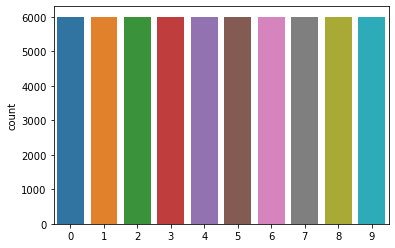

In [17]:
Seed = 111 #For reproducibility

train_dataset = torchvision.datasets.FashionMNIST(root = 'Data', train = True, download = True)

test_dataset = torchvision.datasets.FashionMNIST(root = 'Data', train = False, download = True)

ClassNames = train_dataset.classes           
x_train = train_dataset.data.cpu().numpy()   
y_train = train_dataset.targets.cpu().numpy()
x_test = test_dataset.data.cpu().numpy()     
y_test = test_dataset.targets.cpu().numpy()  

N, H1, W1 = x_train.shape
C1 = 1 #One colour channel
K = 10
D = H1 * W1 #The dimensionality of the dataset
print(f"N: {N}, C1: {C1}, H1: {H1}, W1: {W1}, K: {K}")
print("Class names:", ClassNames)
print(f"\nBefore scaling: Min ({x_train.min()}),   Max ({x_train.max()}), Data type ({x_train.dtype})")

#Original data goes from 0 to 255 but we're scaling it
x_train = (x_train / 255).astype(np.float32)
x_test = (x_test / 255).astype(np.float32)
print(f" After scaling: Min ({x_train.min()}), Max ({x_train.max()}), Data type ({x_train.dtype})")

print(f"\nX_Train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape : {x_test.shape}, y_test shape : {y_test.shape}")

sns.countplot(y_train)
plt.show()

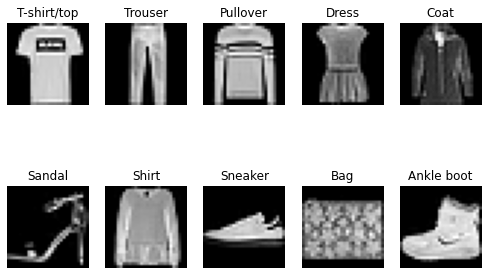

In [4]:
orig = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [8.5, 5.5]
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5)
ax1.imshow(x_train[np.argmax(y_train == 0)], cmap = 'gray')
ax1.set_title(ClassNames[0])
ax1.axis('off')
ax2.imshow(x_train[np.argmax(y_train == 1)], cmap = 'gray')
ax2.set_title(ClassNames[1])
ax2.axis('off')
ax3.imshow(x_train[np.argmax(y_train == 2)], cmap = 'gray')
ax3.set_title(ClassNames[2])
ax3.axis('off')
ax4.imshow(x_train[np.argmax(y_train == 3)], cmap = 'gray')
ax4.set_title(ClassNames[3])
ax4.axis('off')
ax5.imshow(x_train[np.argmax(y_train == 4)], cmap = 'gray')
ax5.set_title(ClassNames[4])
ax5.axis('off')
ax6.imshow(x_train[np.argmax(y_train == 5)], cmap = 'gray')
ax6.set_title(ClassNames[5])
ax6.axis('off')
ax7.imshow(x_train[np.argmax(y_train == 6)], cmap = 'gray')
ax7.set_title(ClassNames[6])
ax7.axis('off')
ax8.imshow(x_train[np.argmax(y_train == 7)], cmap = 'gray')
ax8.set_title(ClassNames[7])
ax8.axis('off')
ax9.imshow(x_train[np.argmax(y_train == 8)], cmap = 'gray')
ax9.set_title(ClassNames[8])
ax9.axis('off')
ax10.imshow(x_train[np.argmax(y_train == 9)], cmap = 'gray')
ax10.set_title(ClassNames[9])
ax10.axis('off')
plt.show()
plt.rcParams['figure.figsize'] = orig

# Functions

# Neural Network

## Architecture

In [5]:
class NeuralNet():    
    def __init__(self, nonlinearitys, size, widths):
        self.nonlinearitys = nonlinearitys
        self.size = size
        self.widths = widths
        self.layers = []
        
        old_size = self.size
        for layer in range(len(self.widths)):
            size = self.widths[layer]
            self.layers.append(linear(nonlinearity = self.nonlinearitys[layer], dkernel = None, dbias = None, gradkernel = None, gradbias = None, kernel = np.random.normal(size = (old_size, size)) / np.sqrt(old_size), bias = np.random.normal(size = size)))
            old_size = size
    
    def predict(self, x):
        res = x.reshape(len(x), -1)
        for i in range(len(self.widths)):
            res = self.layers[i].predict(res)
        return res
    
    def backprop(self, y, y_hat, lr):
        self.layers[-1].dkernel = self.layers[-1].d_out_kernel(y, y_hat, self.widths[-1])
        self.layers[-1].dbias = self.layers[-1].d_out_bias()
        self.layers[-1].gradkernel = self.layers[-1].grad_kernel()
        self.layers[-1].gradbias = self.layers[-1].grad_bias()
        self.layers[-1].take_step(lr)
        
        if len(self.widths) > 1:
            for layer in range(len(self.widths) - 2, -1, -1):
                self.layers[layer].dkernel = self.layers[layer].d_kernel(self.layers[layer+1].dkernel, self.layers[layer+1].kernel, self.layers[layer+1].x, self.layers[layer].nonlinearity)
                self.layers[layer].dbias = self.layers[layer].d_bias()
                self.layers[layer].gradkernel = self.layers[layer].grad_kernel()
                self.layers[layer].gradbias = self.layers[layer].grad_bias()
                self.layers[layer].take_step(lr)
    
    def train(self):
        for layer in range(len(self.widths)):
            self.layers[layer].train()
    
    def evaluate(self):
        for layer in range(len(self.widths)):
            self.layers[layer].evaluate()
    
    def __len__(self):
        return len(self.widths)

In [6]:
def softmax(a):
    return np.exp(a) / np.sum(np.exp(a), axis = 1, keepdims = True)

def relu(a):
    return a * (a > 0)

def sigmoid(a):
    if np.all(a >= 0):
        return 1 / (1 + np.exp(-a))
    else:
        return np.exp(a) / (1 + np.exp(a))

def loss(y, y_hat):
    return -np.mean(y * np.log(y_hat))

class linear():    
    def __init__(self, nonlinearity, dkernel, dbias, gradkernel, gradbias, kernel, bias):
        self.nonlinearity = nonlinearity
        self.dkernel = dkernel
        self.dbias = dbias
        self.gradkernel = gradkernel
        self.gradbias = gradbias
        self.kernel = kernel
        self.bias = bias
        self.x = None
        self.is_training = False
        
    def evaluate(self):
        self.is_training = False
    
    def train(self):
        self.is_training = True
        
    def take_step(self, lr):
        self.kernel = self.kernel - (lr * self.gradkernel)
        self.bias = self.bias - (lr * self.gradbias)
        
    def predict(self, X):
        if self.is_training:
            self.x = X.copy()
        Res = X.dot(self.kernel) + self.bias
        Res = sigmoid(Res) if self.nonlinearity.lower() == "sigmoid" else relu(Res) if self.nonlinearity.lower() == "relu" else softmax(Res)
        return Res
    
    def grad_relu(self, x):
        return np.sign(x)
        
    def grad_sigmoid(self, x):
        return x * (1 - x)
        
    def grad_kernel(self):
        return self.x.T.dot(self.dkernel)
        
    def grad_bias(self):
        return self.dbias.copy()
    
    def d_kernel(self, Delta, kernel, x, nonlinearity):
        return Delta.dot(kernel.T) * (self.grad_sigmoid(x) if nonlinearity.lower() == "sigmoid" else self.grad_relu(x))
    
    def d_bias(self):
        return np.sum(self.dkernel.copy(), axis = 0)
    
    def d_out_kernel(self, y, y_hat, K):
        return y_hat - y_probs(y, K)
        
    def d_out_bias(self):
        return np.sum(self.dkernel.copy(), axis = 0)

## Hyperparameters 1

### Neural Network Model

In [17]:
nonlinearities = ["sigmoid", "sigmoid"] + ["softmax"] #Last is softmax for multiclass classification
widths = [140, 80, K]
model = NeuralNet(nonlinearities, D, widths)

### Optimisation

In [18]:
iterations = 300
lr = 1e-5
train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

In [19]:
for iteration in range(iterations):
    model.train()
    
    y_prob = model.predict(x_train)
    y_hat = np.argmax(y_prob, axis = 1)
    actual_prob = y_probs(y_train, K)
    
    loss_train = loss(actual_prob, y_prob)
    accuracy_train = np.mean(y_hat == y_train)
    
    model.backprop(y_train, y_prob, lr)
    model.evaluate()
    
    y_prob_test = model.predict(x_test)
    y_hat_test = np.argmax(y_prob_test, axis = 1)
    actual_test_prob = y_probs(y_test, K)
    
    loss_test = loss(actual_test_prob, y_prob_test)
    accuracy_test = np.mean(y_hat_test == y_test)
    
    train_losses.append(loss_train)
    train_accuracies.append(accuracy_train)
    
    test_losses.append(loss_test)
    test_accuracies.append(accuracy_test)
    
    if (iteration + 1) % 1 == 0 or iteration == iterations - 1 or iteration == 0:
        print(f'Iteration {iteration + 1}/{iterations}. Train loss: {loss_train:.4f}, Train acc: {accuracy_train:.2f} - Test loss: {loss_test:.4f}, Test acc: {accuracy_test:.2f}')

Iteration 1/300. Train loss: 0.2777, Train acc: 0.10 - Test loss: 0.2489, Test acc: 0.10
Iteration 2/300. Train loss: 0.2488, Train acc: 0.10 - Test loss: 0.2333, Test acc: 0.12
Iteration 3/300. Train loss: 0.2332, Train acc: 0.12 - Test loss: 0.2307, Test acc: 0.18
Iteration 4/300. Train loss: 0.2307, Train acc: 0.18 - Test loss: 0.2298, Test acc: 0.17
Iteration 5/300. Train loss: 0.2297, Train acc: 0.17 - Test loss: 0.2291, Test acc: 0.26
Iteration 6/300. Train loss: 0.2291, Train acc: 0.26 - Test loss: 0.2287, Test acc: 0.21
Iteration 7/300. Train loss: 0.2287, Train acc: 0.21 - Test loss: 0.2283, Test acc: 0.27
Iteration 8/300. Train loss: 0.2283, Train acc: 0.27 - Test loss: 0.2279, Test acc: 0.27
Iteration 9/300. Train loss: 0.2279, Train acc: 0.27 - Test loss: 0.2275, Test acc: 0.33
Iteration 10/300. Train loss: 0.2275, Train acc: 0.33 - Test loss: 0.2272, Test acc: 0.39
Iteration 11/300. Train loss: 0.2271, Train acc: 0.40 - Test loss: 0.2268, Test acc: 0.45
Iteration 12/300. T

Iteration 93/300. Train loss: 0.1092, Train acc: 0.65 - Test loss: 0.1093, Test acc: 0.65
Iteration 94/300. Train loss: 0.1085, Train acc: 0.65 - Test loss: 0.1086, Test acc: 0.65
Iteration 95/300. Train loss: 0.1079, Train acc: 0.65 - Test loss: 0.1080, Test acc: 0.65
Iteration 96/300. Train loss: 0.1072, Train acc: 0.65 - Test loss: 0.1074, Test acc: 0.65
Iteration 97/300. Train loss: 0.1066, Train acc: 0.65 - Test loss: 0.1068, Test acc: 0.65
Iteration 98/300. Train loss: 0.1060, Train acc: 0.65 - Test loss: 0.1062, Test acc: 0.65
Iteration 99/300. Train loss: 0.1054, Train acc: 0.66 - Test loss: 0.1056, Test acc: 0.66
Iteration 100/300. Train loss: 0.1048, Train acc: 0.66 - Test loss: 0.1051, Test acc: 0.66
Iteration 101/300. Train loss: 0.1042, Train acc: 0.66 - Test loss: 0.1045, Test acc: 0.66
Iteration 102/300. Train loss: 0.1037, Train acc: 0.66 - Test loss: 0.1040, Test acc: 0.66
Iteration 103/300. Train loss: 0.1031, Train acc: 0.66 - Test loss: 0.1034, Test acc: 0.66
Iterat

Iteration 184/300. Train loss: 0.0731, Train acc: 0.74 - Test loss: 0.0744, Test acc: 0.73
Iteration 185/300. Train loss: 0.0729, Train acc: 0.74 - Test loss: 0.0742, Test acc: 0.73
Iteration 186/300. Train loss: 0.0727, Train acc: 0.74 - Test loss: 0.0740, Test acc: 0.73
Iteration 187/300. Train loss: 0.0725, Train acc: 0.74 - Test loss: 0.0738, Test acc: 0.73
Iteration 188/300. Train loss: 0.0723, Train acc: 0.74 - Test loss: 0.0736, Test acc: 0.73
Iteration 189/300. Train loss: 0.0721, Train acc: 0.74 - Test loss: 0.0734, Test acc: 0.74
Iteration 190/300. Train loss: 0.0719, Train acc: 0.74 - Test loss: 0.0732, Test acc: 0.74
Iteration 191/300. Train loss: 0.0717, Train acc: 0.74 - Test loss: 0.0730, Test acc: 0.74
Iteration 192/300. Train loss: 0.0715, Train acc: 0.74 - Test loss: 0.0729, Test acc: 0.74
Iteration 193/300. Train loss: 0.0713, Train acc: 0.74 - Test loss: 0.0727, Test acc: 0.74
Iteration 194/300. Train loss: 0.0712, Train acc: 0.74 - Test loss: 0.0725, Test acc: 0.74

Iteration 275/300. Train loss: 0.0619, Train acc: 0.77 - Test loss: 0.0637, Test acc: 0.76
Iteration 276/300. Train loss: 0.0618, Train acc: 0.77 - Test loss: 0.0636, Test acc: 0.76
Iteration 277/300. Train loss: 0.0617, Train acc: 0.77 - Test loss: 0.0635, Test acc: 0.76
Iteration 278/300. Train loss: 0.0616, Train acc: 0.77 - Test loss: 0.0634, Test acc: 0.76
Iteration 279/300. Train loss: 0.0616, Train acc: 0.77 - Test loss: 0.0634, Test acc: 0.76
Iteration 280/300. Train loss: 0.0615, Train acc: 0.77 - Test loss: 0.0633, Test acc: 0.76
Iteration 281/300. Train loss: 0.0614, Train acc: 0.77 - Test loss: 0.0632, Test acc: 0.76
Iteration 282/300. Train loss: 0.0613, Train acc: 0.77 - Test loss: 0.0632, Test acc: 0.76
Iteration 283/300. Train loss: 0.0613, Train acc: 0.77 - Test loss: 0.0631, Test acc: 0.77
Iteration 284/300. Train loss: 0.0612, Train acc: 0.77 - Test loss: 0.0630, Test acc: 0.77
Iteration 285/300. Train loss: 0.0611, Train acc: 0.77 - Test loss: 0.0630, Test acc: 0.77

### Evaluation

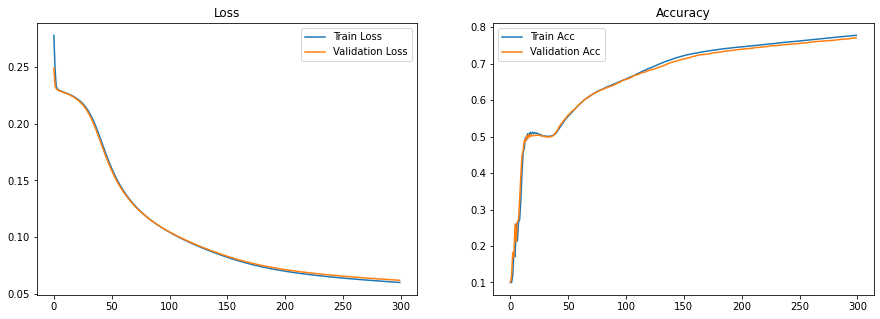

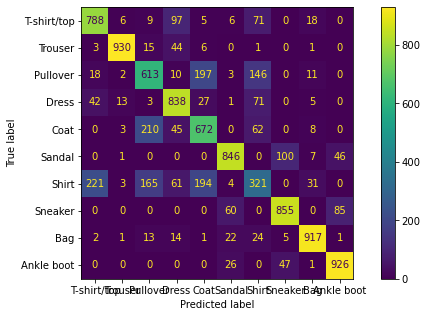

In [20]:
#Plotting the metrics for Train and Test sets
orig = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Loss")
ax1.plot(train_losses, label = f"Train Loss")
ax1.plot(test_losses, label = f"Validation Loss")
ax1.legend()
ax2.set_title("Accuracy")
ax2.plot(train_accuracies, label = f"Train Acc")
ax2.plot(test_accuracies, label = f"Validation Acc")
ax2.legend()
plt.show()
plt.rcParams['figure.figsize'] = orig

#Plotting the confusion matrix
orig = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 5]
ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat_test), display_labels = ClassNames).plot()
plt.show()
plt.rcParams['figure.figsize'] = orig

## Hyperparameters 2

### Neural Network Model

In [7]:
nonlinearities = ["relu", "relu"] + ["softmax"] #Last is softmax for multiclass classification
widths = [140, 80, K]
model = NeuralNet(nonlinearities, D, widths)

### Optimisation

In [8]:
iterations = 300
lr = 6e-7
train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

In [9]:
for iteration in range(iterations):
    model.train()
    
    y_prob = model.predict(x_train)
    y_hat = np.argmax(y_prob, axis = 1)
    actual_prob = y_probs(y_train, K)
    
    loss_train = loss(actual_prob, y_prob)
    accuracy_train = np.mean(y_hat == y_train)
    
    model.backprop(y_train, y_prob, lr)
    model.evaluate()
    
    y_prob_test = model.predict(x_test)
    y_hat_test = np.argmax(y_prob_test, axis = 1)
    actual_test_prob = y_probs(y_test, K)
    
    loss_test = loss(actual_test_prob, y_prob_test)
    accuracy_test = np.mean(y_hat_test == y_test)
    
    train_losses.append(loss_train)
    train_accuracies.append(accuracy_train)
    
    test_losses.append(loss_test)
    test_accuracies.append(accuracy_test)
    
    if (iteration + 1) % 1 == 0 or iteration == iterations - 1 or iteration == 0:
        print(f'Iteration {iteration + 1}/{iterations}. Train loss: {loss_train:.4f}, Train acc: {accuracy_train:.2f} - Test loss: {loss_test:.4f}, Test acc: {accuracy_test:.2f}')

Iteration 1/300. Train loss: 0.2817, Train acc: 0.09 - Test loss: 0.2422, Test acc: 0.10
Iteration 2/300. Train loss: 0.2422, Train acc: 0.09 - Test loss: 0.2285, Test acc: 0.14
Iteration 3/300. Train loss: 0.2284, Train acc: 0.14 - Test loss: 0.2210, Test acc: 0.17
Iteration 4/300. Train loss: 0.2210, Train acc: 0.18 - Test loss: 0.2165, Test acc: 0.24
Iteration 5/300. Train loss: 0.2164, Train acc: 0.23 - Test loss: 0.2130, Test acc: 0.33
Iteration 6/300. Train loss: 0.2130, Train acc: 0.33 - Test loss: 0.2098, Test acc: 0.39
Iteration 7/300. Train loss: 0.2098, Train acc: 0.39 - Test loss: 0.2068, Test acc: 0.42
Iteration 8/300. Train loss: 0.2068, Train acc: 0.42 - Test loss: 0.2038, Test acc: 0.44
Iteration 9/300. Train loss: 0.2038, Train acc: 0.44 - Test loss: 0.2006, Test acc: 0.47
Iteration 10/300. Train loss: 0.2006, Train acc: 0.47 - Test loss: 0.1974, Test acc: 0.48
Iteration 11/300. Train loss: 0.1974, Train acc: 0.48 - Test loss: 0.1943, Test acc: 0.50
Iteration 12/300. T

Iteration 93/300. Train loss: 0.0864, Train acc: 0.72 - Test loss: 0.0869, Test acc: 0.72
Iteration 94/300. Train loss: 0.0861, Train acc: 0.72 - Test loss: 0.0865, Test acc: 0.72
Iteration 95/300. Train loss: 0.0857, Train acc: 0.72 - Test loss: 0.0862, Test acc: 0.72
Iteration 96/300. Train loss: 0.0854, Train acc: 0.72 - Test loss: 0.0859, Test acc: 0.72
Iteration 97/300. Train loss: 0.0851, Train acc: 0.72 - Test loss: 0.0856, Test acc: 0.72
Iteration 98/300. Train loss: 0.0848, Train acc: 0.72 - Test loss: 0.0853, Test acc: 0.72
Iteration 99/300. Train loss: 0.0845, Train acc: 0.72 - Test loss: 0.0850, Test acc: 0.72
Iteration 100/300. Train loss: 0.0842, Train acc: 0.72 - Test loss: 0.0847, Test acc: 0.72
Iteration 101/300. Train loss: 0.0839, Train acc: 0.73 - Test loss: 0.0844, Test acc: 0.72
Iteration 102/300. Train loss: 0.0836, Train acc: 0.73 - Test loss: 0.0841, Test acc: 0.72
Iteration 103/300. Train loss: 0.0833, Train acc: 0.73 - Test loss: 0.0839, Test acc: 0.72
Iterat

Iteration 184/300. Train loss: 0.0697, Train acc: 0.75 - Test loss: 0.0708, Test acc: 0.75
Iteration 185/300. Train loss: 0.0696, Train acc: 0.75 - Test loss: 0.0707, Test acc: 0.75
Iteration 186/300. Train loss: 0.0695, Train acc: 0.75 - Test loss: 0.0706, Test acc: 0.75
Iteration 187/300. Train loss: 0.0694, Train acc: 0.76 - Test loss: 0.0705, Test acc: 0.75
Iteration 188/300. Train loss: 0.0693, Train acc: 0.76 - Test loss: 0.0704, Test acc: 0.75
Iteration 189/300. Train loss: 0.0692, Train acc: 0.76 - Test loss: 0.0703, Test acc: 0.75
Iteration 190/300. Train loss: 0.0691, Train acc: 0.76 - Test loss: 0.0702, Test acc: 0.75
Iteration 191/300. Train loss: 0.0690, Train acc: 0.76 - Test loss: 0.0701, Test acc: 0.75
Iteration 192/300. Train loss: 0.0689, Train acc: 0.76 - Test loss: 0.0700, Test acc: 0.75
Iteration 193/300. Train loss: 0.0688, Train acc: 0.76 - Test loss: 0.0699, Test acc: 0.75
Iteration 194/300. Train loss: 0.0687, Train acc: 0.76 - Test loss: 0.0698, Test acc: 0.75

Iteration 275/300. Train loss: 0.0627, Train acc: 0.78 - Test loss: 0.0642, Test acc: 0.77
Iteration 276/300. Train loss: 0.0627, Train acc: 0.78 - Test loss: 0.0641, Test acc: 0.77
Iteration 277/300. Train loss: 0.0627, Train acc: 0.78 - Test loss: 0.0642, Test acc: 0.77
Iteration 278/300. Train loss: 0.0627, Train acc: 0.77 - Test loss: 0.0642, Test acc: 0.77
Iteration 279/300. Train loss: 0.0627, Train acc: 0.78 - Test loss: 0.0644, Test acc: 0.76
Iteration 280/300. Train loss: 0.0628, Train acc: 0.77 - Test loss: 0.0643, Test acc: 0.77
Iteration 281/300. Train loss: 0.0629, Train acc: 0.77 - Test loss: 0.0648, Test acc: 0.76
Iteration 282/300. Train loss: 0.0632, Train acc: 0.77 - Test loss: 0.0648, Test acc: 0.77
Iteration 283/300. Train loss: 0.0634, Train acc: 0.77 - Test loss: 0.0655, Test acc: 0.75
Iteration 284/300. Train loss: 0.0639, Train acc: 0.76 - Test loss: 0.0656, Test acc: 0.76
Iteration 285/300. Train loss: 0.0641, Train acc: 0.77 - Test loss: 0.0668, Test acc: 0.75

### Evaluation

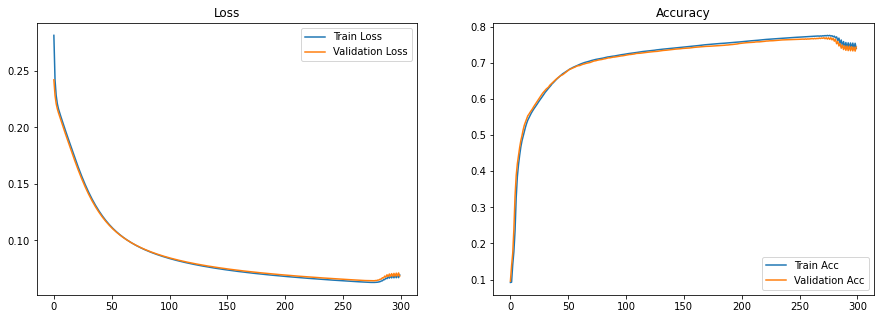

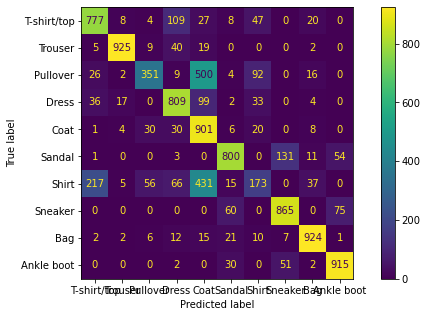

In [10]:
#Plotting the metrics for Train and Test sets
orig = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Loss")
ax1.plot(train_losses, label = f"Train Loss")
ax1.plot(test_losses, label = f"Validation Loss")
ax1.legend()
ax2.set_title("Accuracy")
ax2.plot(train_accuracies, label = f"Train Acc")
ax2.plot(test_accuracies, label = f"Validation Acc")
ax2.legend()
plt.show()
plt.rcParams['figure.figsize'] = orig

#Plotting the confusion matrix
orig = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 5]
ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat_test), display_labels = ClassNames).plot()
plt.show()
plt.rcParams['figure.figsize'] = orig

## Hyperparameters 3

### Neural Network Model

In [11]:
nonlinearities = ["relu", "relu"] + ["softmax"] #Last is softmax for multiclass classification
widths = [100, 200, K]
model = NeuralNet(nonlinearities, D, widths)

### Optimisation

In [12]:
iterations = 300
lr = 1e-7
train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

In [13]:
for iteration in range(iterations):
    model.train()
    
    y_prob = model.predict(x_train)
    y_hat = np.argmax(y_prob, axis = 1)
    actual_prob = y_probs(y_train, K)
    
    loss_train = loss(actual_prob, y_prob)
    accuracy_train = np.mean(y_hat == y_train)
    
    model.backprop(y_train, y_prob, lr)
    model.evaluate()
    
    y_prob_test = model.predict(x_test)
    y_hat_test = np.argmax(y_prob_test, axis = 1)
    actual_test_prob = y_probs(y_test, K)
    
    loss_test = loss(actual_test_prob, y_prob_test)
    accuracy_test = np.mean(y_hat_test == y_test)
    
    train_losses.append(loss_train)
    train_accuracies.append(accuracy_train)
    
    test_losses.append(loss_test)
    test_accuracies.append(accuracy_test)
    
    if (iteration + 1) % 1 == 0 or iteration == iterations - 1 or iteration == 0:
        print(f'Iteration {iteration + 1}/{iterations}. Train loss: {loss_train:.4f}, Train acc: {accuracy_train:.2f} - Test loss: {loss_test:.4f}, Test acc: {accuracy_test:.2f}')

Iteration 1/300. Train loss: 0.2594, Train acc: 0.10 - Test loss: 0.2539, Test acc: 0.10
Iteration 2/300. Train loss: 0.2540, Train acc: 0.10 - Test loss: 0.2495, Test acc: 0.10
Iteration 3/300. Train loss: 0.2496, Train acc: 0.10 - Test loss: 0.2459, Test acc: 0.11
Iteration 4/300. Train loss: 0.2459, Train acc: 0.10 - Test loss: 0.2428, Test acc: 0.11
Iteration 5/300. Train loss: 0.2429, Train acc: 0.10 - Test loss: 0.2402, Test acc: 0.11
Iteration 6/300. Train loss: 0.2402, Train acc: 0.11 - Test loss: 0.2379, Test acc: 0.11
Iteration 7/300. Train loss: 0.2380, Train acc: 0.11 - Test loss: 0.2360, Test acc: 0.11
Iteration 8/300. Train loss: 0.2360, Train acc: 0.11 - Test loss: 0.2343, Test acc: 0.11
Iteration 9/300. Train loss: 0.2343, Train acc: 0.11 - Test loss: 0.2328, Test acc: 0.11
Iteration 10/300. Train loss: 0.2328, Train acc: 0.11 - Test loss: 0.2314, Test acc: 0.12
Iteration 11/300. Train loss: 0.2315, Train acc: 0.12 - Test loss: 0.2302, Test acc: 0.12
Iteration 12/300. T

Iteration 93/300. Train loss: 0.1925, Train acc: 0.59 - Test loss: 0.1923, Test acc: 0.59
Iteration 94/300. Train loss: 0.1921, Train acc: 0.59 - Test loss: 0.1918, Test acc: 0.59
Iteration 95/300. Train loss: 0.1916, Train acc: 0.59 - Test loss: 0.1914, Test acc: 0.59
Iteration 96/300. Train loss: 0.1912, Train acc: 0.59 - Test loss: 0.1910, Test acc: 0.59
Iteration 97/300. Train loss: 0.1908, Train acc: 0.59 - Test loss: 0.1905, Test acc: 0.59
Iteration 98/300. Train loss: 0.1903, Train acc: 0.59 - Test loss: 0.1901, Test acc: 0.59
Iteration 99/300. Train loss: 0.1899, Train acc: 0.59 - Test loss: 0.1896, Test acc: 0.59
Iteration 100/300. Train loss: 0.1895, Train acc: 0.59 - Test loss: 0.1892, Test acc: 0.59
Iteration 101/300. Train loss: 0.1890, Train acc: 0.59 - Test loss: 0.1888, Test acc: 0.60
Iteration 102/300. Train loss: 0.1886, Train acc: 0.60 - Test loss: 0.1883, Test acc: 0.60
Iteration 103/300. Train loss: 0.1881, Train acc: 0.60 - Test loss: 0.1879, Test acc: 0.60
Iterat

Iteration 184/300. Train loss: 0.1531, Train acc: 0.67 - Test loss: 0.1532, Test acc: 0.66
Iteration 185/300. Train loss: 0.1527, Train acc: 0.67 - Test loss: 0.1528, Test acc: 0.66
Iteration 186/300. Train loss: 0.1523, Train acc: 0.67 - Test loss: 0.1524, Test acc: 0.66
Iteration 187/300. Train loss: 0.1520, Train acc: 0.67 - Test loss: 0.1520, Test acc: 0.66
Iteration 188/300. Train loss: 0.1516, Train acc: 0.67 - Test loss: 0.1516, Test acc: 0.67
Iteration 189/300. Train loss: 0.1512, Train acc: 0.67 - Test loss: 0.1513, Test acc: 0.67
Iteration 190/300. Train loss: 0.1508, Train acc: 0.67 - Test loss: 0.1509, Test acc: 0.67
Iteration 191/300. Train loss: 0.1505, Train acc: 0.67 - Test loss: 0.1505, Test acc: 0.67
Iteration 192/300. Train loss: 0.1501, Train acc: 0.67 - Test loss: 0.1502, Test acc: 0.67
Iteration 193/300. Train loss: 0.1497, Train acc: 0.67 - Test loss: 0.1498, Test acc: 0.67
Iteration 194/300. Train loss: 0.1493, Train acc: 0.67 - Test loss: 0.1494, Test acc: 0.67

Iteration 275/300. Train loss: 0.1252, Train acc: 0.70 - Test loss: 0.1256, Test acc: 0.70
Iteration 276/300. Train loss: 0.1249, Train acc: 0.70 - Test loss: 0.1254, Test acc: 0.70
Iteration 277/300. Train loss: 0.1247, Train acc: 0.70 - Test loss: 0.1251, Test acc: 0.70
Iteration 278/300. Train loss: 0.1245, Train acc: 0.70 - Test loss: 0.1249, Test acc: 0.70
Iteration 279/300. Train loss: 0.1242, Train acc: 0.70 - Test loss: 0.1247, Test acc: 0.70
Iteration 280/300. Train loss: 0.1240, Train acc: 0.70 - Test loss: 0.1245, Test acc: 0.70
Iteration 281/300. Train loss: 0.1238, Train acc: 0.70 - Test loss: 0.1242, Test acc: 0.70
Iteration 282/300. Train loss: 0.1235, Train acc: 0.70 - Test loss: 0.1240, Test acc: 0.70
Iteration 283/300. Train loss: 0.1233, Train acc: 0.70 - Test loss: 0.1238, Test acc: 0.70
Iteration 284/300. Train loss: 0.1231, Train acc: 0.70 - Test loss: 0.1236, Test acc: 0.70
Iteration 285/300. Train loss: 0.1228, Train acc: 0.70 - Test loss: 0.1233, Test acc: 0.70

### Evaluation

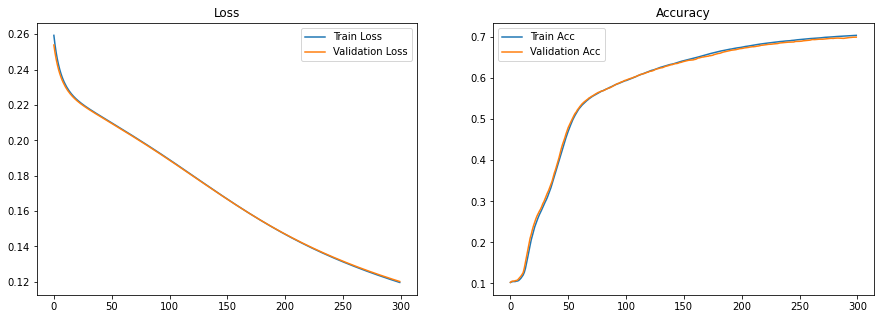

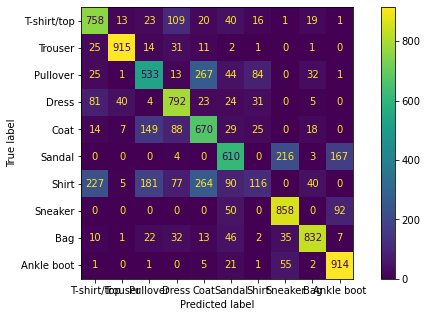

In [15]:
#Plotting the metrics for Train and Test sets
orig = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Loss")
ax1.plot(train_losses, label = f"Train Loss")
ax1.plot(test_losses, label = f"Validation Loss")
ax1.legend()
ax2.set_title("Accuracy")
ax2.plot(train_accuracies, label = f"Train Acc")
ax2.plot(test_accuracies, label = f"Validation Acc")
ax2.legend()
plt.show()
plt.rcParams['figure.figsize'] = orig

#Plotting the confusion matrix
orig = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 5]
ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat_test), display_labels = ClassNames).plot()
plt.show()
plt.rcParams['figure.figsize'] = orig